# Theme Park Wait Time Analysis

This notebook combines data preprocessing, exploratory data analysis, and model creation for theme park wait time prediction.

## Part 1: Data Merging and Preprocessing

### Import Libraries and Setup

In [10]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


### Wait Time Special Codes
- 0: Attraction open (no wait)
- -1: Virtual Queue
- -2: Maintenance
- -3: Closed due to weather
- -4: Attraction closed
- 91: Over 90 minutes wait

In [11]:
# Folder with the Excel files
folder_path = "/home/ms/hfu/ML/ML_Presentation_Workspace/EU_PARK/europark_raw_files" # Corrected absolute path

# Regex to extract attraction, month, and year from filename
pattern = r'^(.*?) - Queue times in (\w+) (\d{4})\.xlsx'

# Dictionary to hold data for each attraction
attraction_data = {}

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.xlsx'):
        match = re.match(pattern, filename)
        if match:
            attraction = match.group(1).strip()
            month = match.group(2)
            year = int(match.group(3))
            file_path = os.path.join(folder_path, filename)

            # Read the file
            df = pd.read_excel(file_path)

            # Add metadata
            df['Month'] = month
            df['Year'] = year

            # Rename columns for consistency
            df.columns = ['Datetime', 'WaitTime', 'Month', 'Year']

            # Add to the attraction's list
            if attraction not in attraction_data:
                attraction_data[attraction] = []
            attraction_data[attraction].append(df)

In [12]:
# For each attraction, combine all months and save one Excel file
safe_attraction_name_list = []
save_path = '/home/ms/hfu/ML/ML_Presentation_Workspace/EU_PARK/europark_attraction_merged_dfs'
for attraction, dfs in attraction_data.items():
    combined_df = pd.concat(dfs, ignore_index=True)

    # Drop rows where Datetime is missing
    combined_df = combined_df.dropna(subset=['Datetime'])

    # Split Datetime into Date and Time using string operations
    combined_df[['Date', 'Time']] = combined_df['Datetime'].astype(str).str.strip().str.split(' ', expand=True)
    safe_attraction_name = attraction.replace('-', ' ')  # avoid file path issues # Create the output file path
    fil_safe_attraction_name = safe_attraction_name.replace(' ','_')
    safe_attraction_name_list.append(fil_safe_attraction_name)
    # print(safe_attraction_name_list)
    output_file = os.path.join(save_path, f"{fil_safe_attraction_name} - All Queue Times.xlsx")
    combined_df.to_excel(output_file, index=False)
    print(f"✅ Saved merged file for: {attraction} -> {output_file}")

✅ Saved merged file for: ARTHUR -> /home/ms/hfu/ML/ML_Presentation_Workspace/EU_PARK/europark_attraction_merged_dfs/ARTHUR - All Queue Times.xlsx


### Merge All attractions in one single excel file

In [13]:
# Folder where individual attraction Excel files are stored
folder_path = 'EU_PARK/europark_attraction_merged_dfs/'

# Get list of merged attraction files
files = [f for f in os.listdir(folder_path) if f.endswith('All Queue Times.xlsx')]
print(files)

['ARTHUR - All Queue Times.xlsx']


In [14]:
merged_df = None

for file in files:
    # Full path to the Excel file
    file_path = os.path.join(folder_path, file)
    
    # Extract attraction name from filename
    attraction = file.replace(' - All Queue Times.xlsx', '').strip()

    # Read file
    df = pd.read_excel(file_path)
    df = df.drop(columns=['Datetime'], errors='ignore')
    df.rename(columns={'WaitTime': f'{attraction}_WaitTime'}, inplace=True)

    # Merge using pandas only
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on=['Date', 'Time', 'Month', 'Year'], how='outer')

merged_df = merged_df.sort_values(by=['Date', 'Time'])

output_file = os.path.join(folder_path, 'All_Attractions_Queue_Times_By_Date_Time.csv')
merged_df.to_csv(output_file, index=False)

print(f"✅ Final merged file saved to: {output_file}")

✅ Final merged file saved to: EU_PARK/europark_attraction_merged_dfs/All_Attractions_Queue_Times_By_Date_Time.csv


In [15]:
merged_df_dt = pd.read_csv("EU_PARK/europark_attraction_merged_dfs/All_Attractions_Queue_Times_By_Date_Time.csv", index_col=False)

# Drop rows with missing Time values
merged_df_dt = merged_df_dt.dropna(subset=['Time'])

# Define a function to report missing values
def report_missing_values(df):
    total_rows = len(df)
    missing_count = df.isna().sum()
    missing_percent = (missing_count / total_rows) * 100

    result = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percent.round(2)
    })
    result = result.sort_values(by='Missing %', ascending=False)

    return result[result['Missing Count'] > 0]  # Only show columns with missing values

# Check missing values
print("Missing values in merged wait time data:")
print(report_missing_values(merged_df_dt))

Missing values in merged wait time data:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


### Merge Weather Data (Temperature, Wind, Precipitation)

In [16]:
def merge_fn_wind_prec_temp(df_path,df_type):
    """
    Parameters:
        df_path (str): Path to folder containing Excel files.
        data_type (str): Type of data ('wind', 'prec', 'temp', etc.)
        
    Returns:
        pd.DataFrame: Combined dataframe with Month and Year columns.
    """
    files = [f for f in os.listdir(df_path) if f.endswith('.xlsx')]
    data_final = []
    for file in files:
        file_path = os.path.join(df_path, file)

        # Extract month and year from filename: 'Wind speed in March 2024.xlsx'
        if df_type == 'wind':
            name_parts = file.replace('.xlsx', '').replace('Wind speed in ', '').strip().split()
        elif df_type == 'prec':
            name_parts = file.replace('.xlsx', '').replace('Precipitation probability in ', '').strip().split()
        elif df_type == 'temp':
            name_parts = file.replace('.xlsx', '').replace('Temperatures in ', '').strip().split()
        else:
            raise ValueError(f"Unknown data_type: {df_type}")
        month = name_parts[0]
        year = name_parts[1]

        # Read the file
        df = pd.read_excel(file_path)

        # Add Month and Year columns
        df['Month'] = month
        df['Year'] = int(year)
        data_final.append(df)

    # Combine all dataframes into one
    wind_df = pd.concat(data_final, ignore_index=True)
    wind_df[['Date', 'Time']] = wind_df['date_time'].astype(str).str.strip().str.split(' ', expand=True)
    wind_df = wind_df.drop(columns=['date_time'])

    return wind_df

In [17]:
# Process Wind, Precipitation, and Temperature data
wind_loc = 'EU_PARK/wind_speed/'
final_wind_df = merge_fn_wind_prec_temp(wind_loc, df_type='wind')

precipitation_loc = '/home/ms/hfu/ML/ML_Presentation_Workspace/EU_PARK/Precipitation/'
final_prec_df = merge_fn_wind_prec_temp(precipitation_loc, df_type='prec')

temperature_loc = 'EU_PARK/Temperatures/'
final_temp_df = merge_fn_wind_prec_temp(temperature_loc, df_type='temp')

print("Wind data shape:", final_wind_df.shape)
print("Precipitation data shape:", final_prec_df.shape)
print("Temperature data shape:", final_temp_df.shape)

Wind data shape: (464598, 5)
Precipitation data shape: (464598, 5)
Temperature data shape: (464598, 5)


### Merge All Data (Wait Times, Temperature, Precipitation, Wind)

In [18]:
# Step-by-step outer merges using pandas only
merged = pd.merge(merged_df_dt, final_temp_df, on=['Month', 'Year', 'Date', 'Time'], how='outer')
merged = pd.merge(merged, final_prec_df, on=['Month', 'Year', 'Date', 'Time'], how='outer')
merged = pd.merge(merged, final_wind_df, on=['Month', 'Year', 'Date', 'Time'], how='outer')

# Optional: sort for clean structure
final_merged = merged.sort_values(by=['Year', 'Month', 'Date', 'Time']).reset_index(drop=True)

print("Final merged dataframe shape:", final_merged.shape)
print("\nMissing values in final merged data:")
print(report_missing_values(final_merged))

Final merged dataframe shape: (549604, 8)

Missing values in final merged data:
                          Missing Count  Missing %
temperature_in_celsius            85828      15.62
precipitation_in_percent          85828      15.62
wind_speed_in_kmh                 85828      15.62
ARTHUR_WaitTime                    2336       0.43
Time                                836       0.15


### Add Holiday Information

In [19]:
# Add school holiday data
school_holiday_df = pd.read_csv('/home/ms/hfu/ML/ML_Presentation_Workspace/EU_PARK/holidays/baden_wuerttemberg_school_holidays_2022_2026.csv')

# Convert both Date columns to datetime
school_holiday_df['Date'] = pd.to_datetime(school_holiday_df['Date'])
final_merged['Date'] = pd.to_datetime(final_merged['Date'], errors='coerce')

# Do a left-merge with indicator
final_merged = pd.merge(
    final_merged,
    school_holiday_df[['Date']],    # only need the Date column
    on='Date',
    how='left',
    indicator=True                  # adds a '_merge' column
)

# Create the flag column (1 if holiday, 0 otherwise)
final_merged['Is_School_Holiday'] = (final_merged['_merge'] == 'both').astype(int)

# Drop the helper '_merge' column
final_merged.drop(columns=['_merge'], inplace=True)

# Add public holiday data
public_holiday_df = pd.read_csv('/home/ms/hfu/ML/ML_Presentation_Workspace/EU_PARK/holidays/baden_wuerttemberg_public_holidays_2022_2025.csv')

# Convert Date column to datetime
public_holiday_df['Date'] = pd.to_datetime(public_holiday_df['Date'])

# Do a left-merge with indicator
final_merged = pd.merge(
    final_merged,
    public_holiday_df[['Date']],    # only need the Date column
    on='Date',
    how='left',
    indicator=True                  # adds a '_merge' column
)

# Create the flag column (1 if holiday, 0 otherwise)
final_merged['Is_Public_Holiday'] = (final_merged['_merge'] == 'both').astype(int)

# Drop the helper '_merge' column
final_merged.drop(columns=['_merge'], inplace=True)

# Save the final merged dataframe
final_merged.to_csv("final_df.csv", index=False)

print("Holiday information added and final dataframe saved to final_df.csv")

Holiday information added and final dataframe saved to final_df.csv


## Part 2: Exploratory Data Analysis and Modeling

### Load Merged Data

In [20]:
# Load the merged dataset
try:
    # Try to load the data from the CSV file
    file_path = 'final_df.csv'  # Update this path if your CSV file is located elsewhere
    final_merged = pd.read_csv(file_path)
    
    # Convert Date column to datetime if it exists
    if 'Date' in final_merged.columns:
        final_merged['Date'] = pd.to_datetime(final_merged['Date'])
    
    print(f"Data loaded successfully. Shape: {final_merged.shape}")
except FileNotFoundError:
    print(f"Error: File not found. Please check if 'final_df.csv' exists in the current directory.")
except Exception as e:
    print(f"Error loading data: {str(e)}")

Data loaded successfully. Shape: (549604, 10)


# Data Pre-processing
Adding park opening and closing hours based on the information available:
- March to November: 9:00 AM to 6:00 PM
- December-January: 11:00 AM to 7:00 PM

In [21]:
def is_park_open(row):
    # Handle month as int or string
    month = row['Month']
    if isinstance(month, str):
        month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 
                     'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
        month = month_map.get(month, None) if not month.isdigit() else int(month)
    # Handle hour extraction robustly
    time_val = row['Time']
    hour = None
    if isinstance(time_val, str):
        try:
            hour = int(time_val.split(':')[0])
        except Exception:
            return 0
    elif not pd.isnull(time_val):
        try:
            hour = pd.to_datetime(time_val).hour
        except Exception:
            return 0
    else:
        return 0
    # Park open logic
    if month is None:
        return 0
    if 3 <= month <= 11:
        return 1 if 9 <= hour < 18 else 0
    elif month in [12, 1]:
        return 1 if 11 <= hour < 19 else 0
    else:
        return 0

final_merged['Park_Open'] = final_merged.apply(is_park_open, axis=1)
print(final_merged['Park_Open'].value_counts())

Park_Open
1    444908
0    104696
Name: count, dtype: int64


# Dataset with only park open hours

In [22]:
# Create a new DataFrame with only park open hours
park_open_df = final_merged[final_merged['Park_Open'] == 1].copy()

# Optional: check the shape or preview
print(park_open_df.shape)
park_open_df.head()

(444908, 11)


,ARTHUR_WaitTime,Month,Year,Date,Time,temperature_in_celsius,precipitation_in_percent,wind_speed_in_kmh,Is_School_Holiday,Is_Public_Holiday,Park_Open
9,1.0,April,2022,2022-04-01,09:00,NaN,NaN,NaN,0,0,1
10,1.0,April,2022,2022-04-01,09:05,NaN,NaN,NaN,0,0,1
11,1.0,April,2022,2022-04-01,09:10,NaN,NaN,NaN,0,0,1
12,1.0,April,2022,2022-04-01,09:15,NaN,NaN,NaN,0,0,1
13,1.0,April,2022,2022-04-01,09:20,NaN,NaN,NaN,0,0,1


In [23]:
#save the DataFrame to a new CSV file
output_file_path = 'park_open_hours.csv'
park_open_df.to_csv(output_file_path, index=False)

### Wait Time Analysis using Special Codes
- 0: Attraction open (no wait)
- -1: Virtual Queue
- -2: Maintenance
- -3: Closed due to weather
- -4: Attraction closed
- 91: Over 90 minutes wait

The following analysis has been performed with use of LLM.

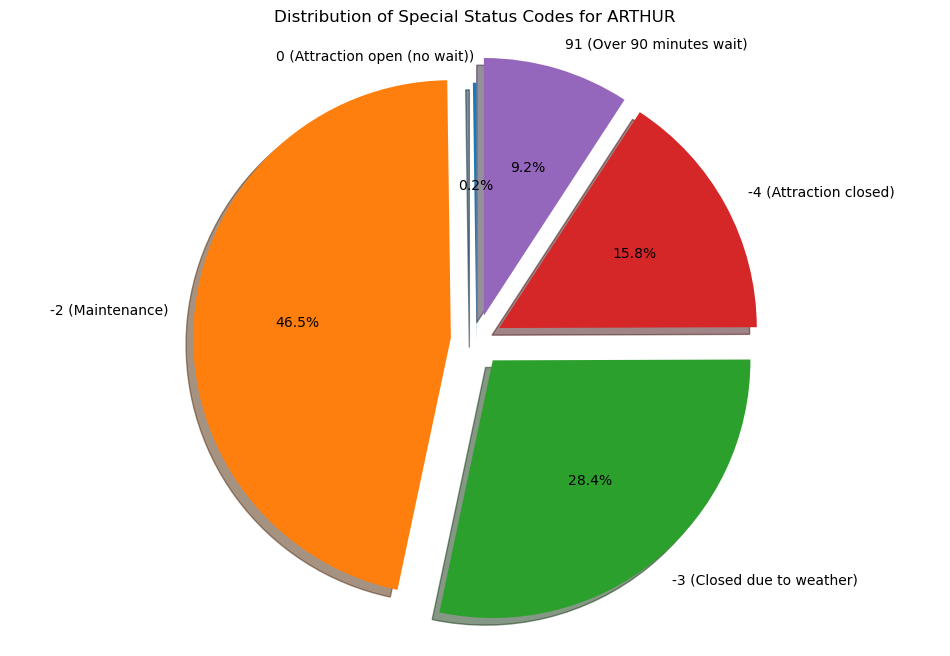

Distribution of special status codes across attractions:


,0 (Attraction open (no wait)),-1 (Virtual Queue),-2 (Maintenance),-3 (Closed due to weather),-4 (Attraction closed),91 (Over 90 minutes wait)
ARTHUR,25 (0.0%),0 (0.0%),5180 (1.2%),3164 (0.7%),1757 (0.4%),1025 (0.2%)


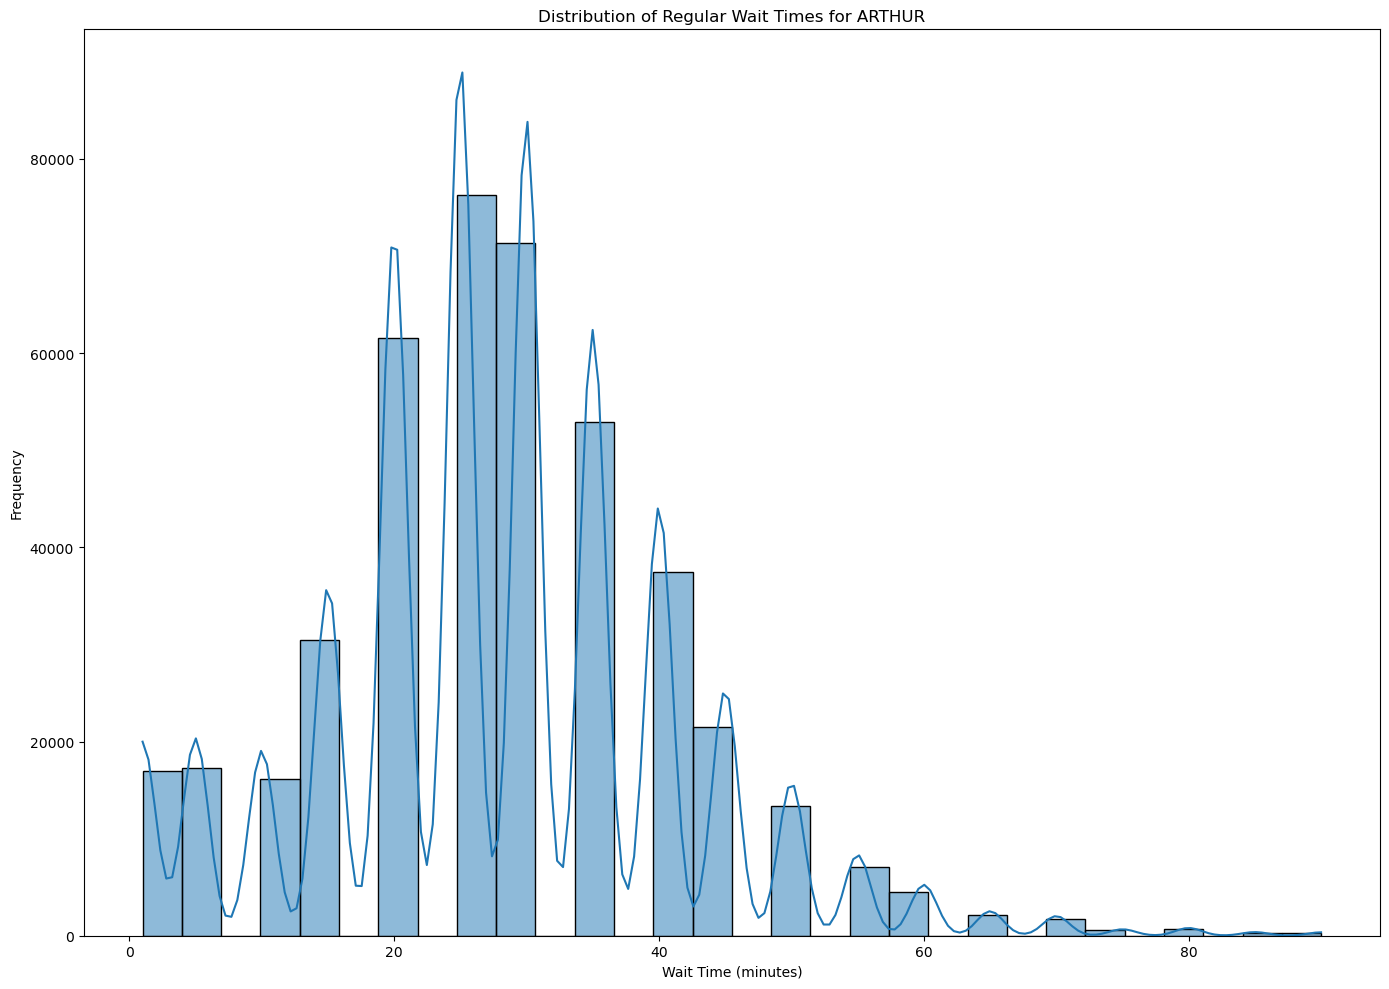

/tmp/ipykernel_615650/3431198905.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_time['Hour'] = pd.to_datetime(df_time['Time']).dt.hour


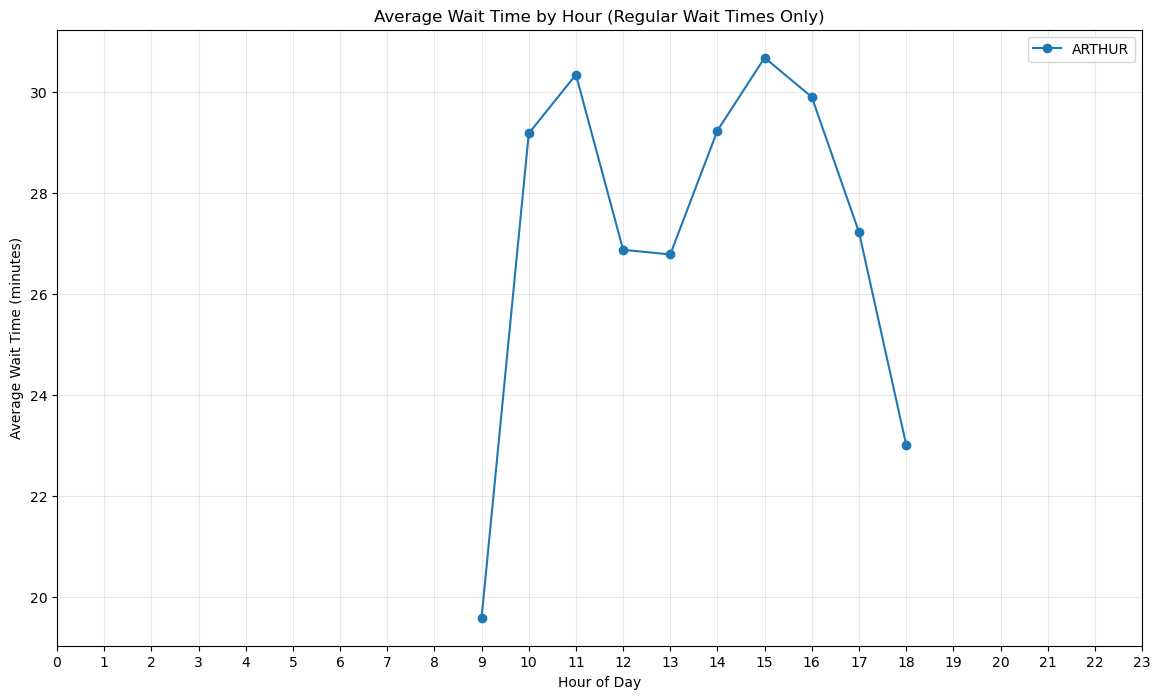

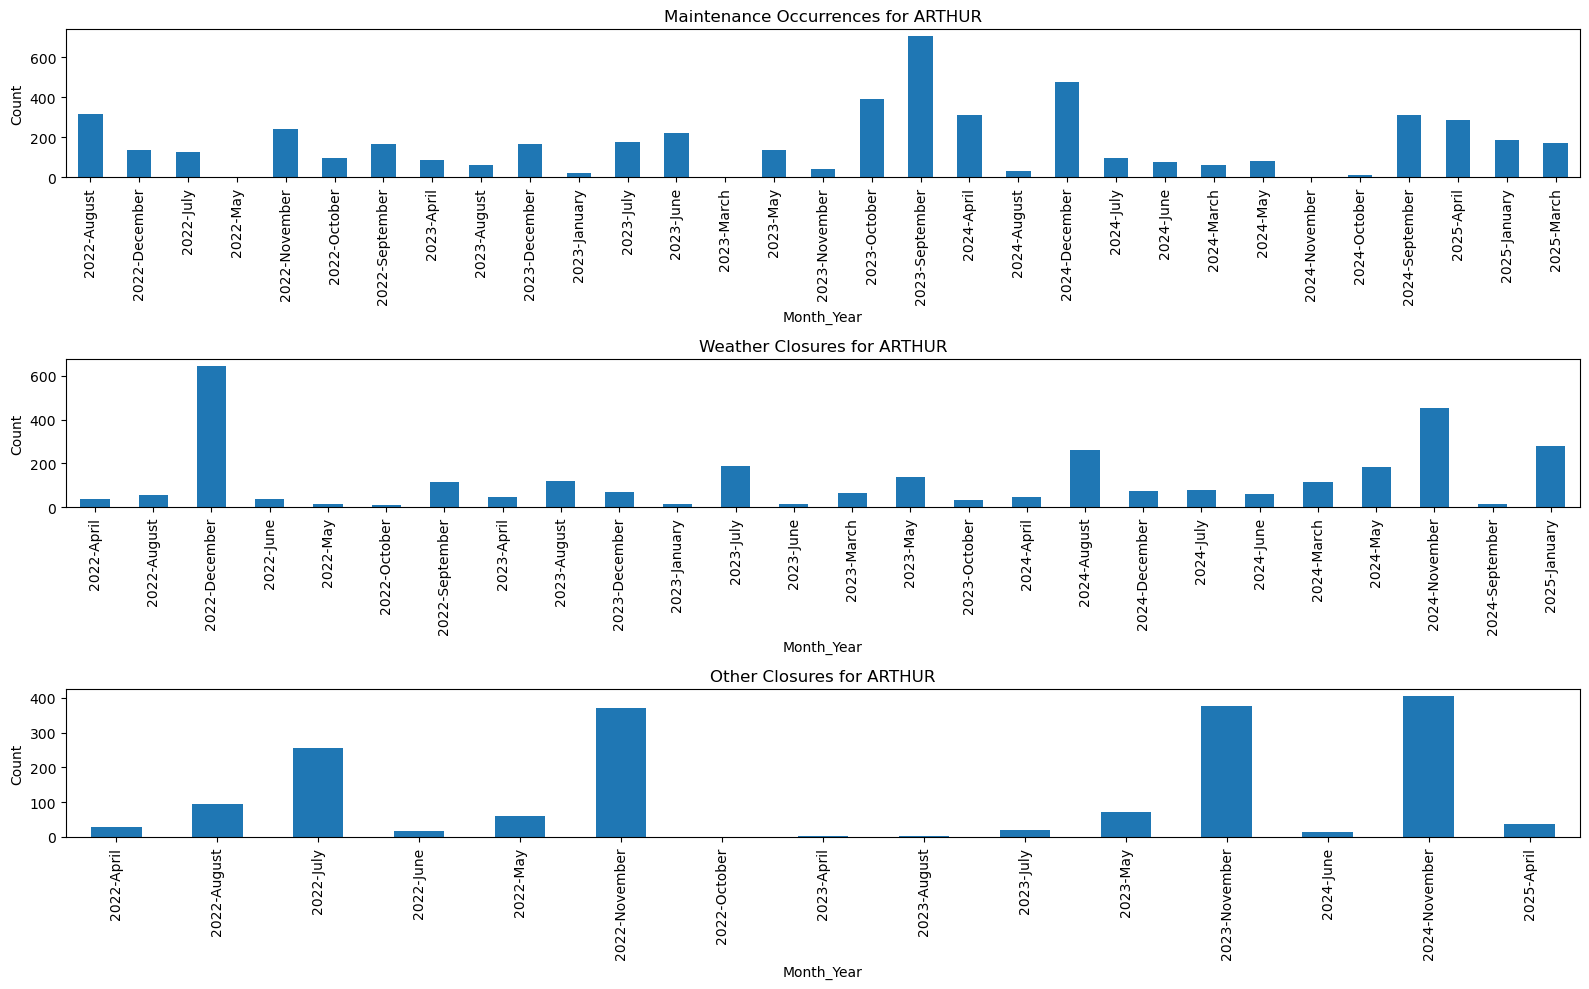

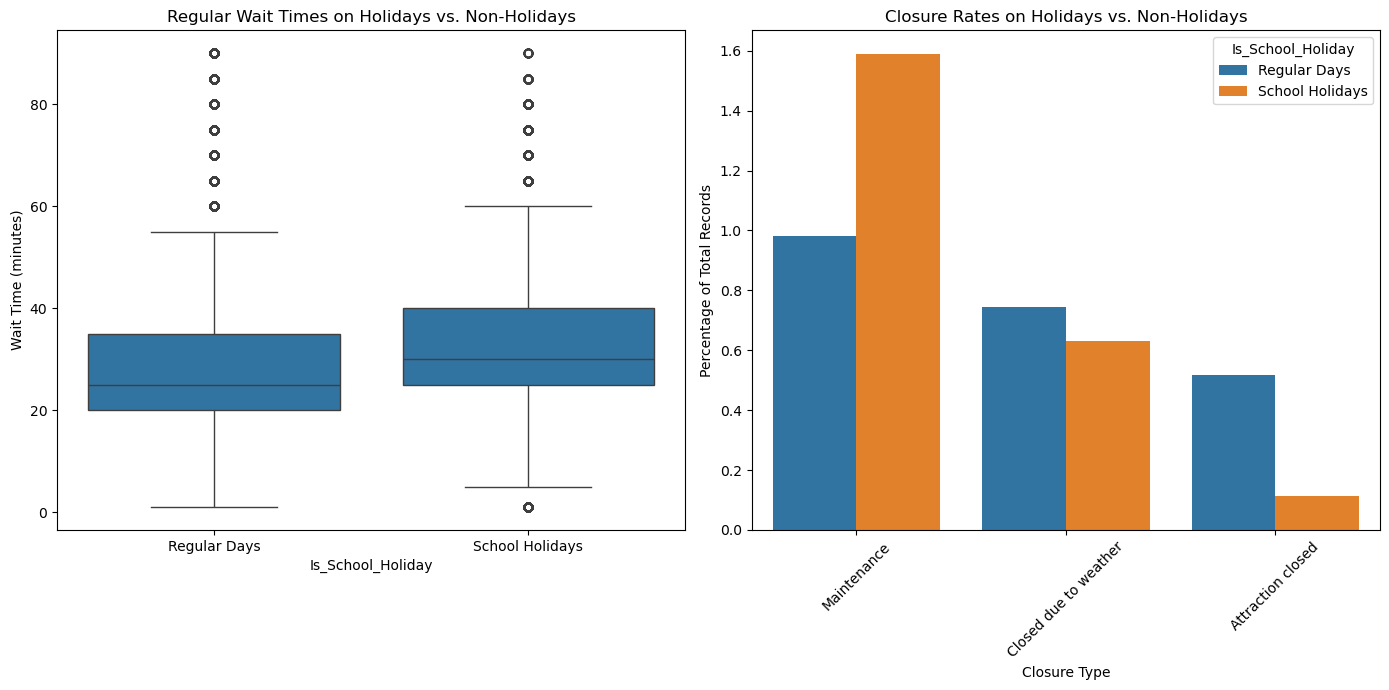

In [24]:
# Analysis of wait time special codes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the meaning of special codes
wait_time_codes = {
    0: "Attraction open (no wait)",
    -1: "Virtual Queue",
    -2: "Maintenance",
    -3: "Closed due to weather",
    -4: "Attraction closed",
    91: "Over 90 minutes wait"
}

# Get all columns with WaitTime in their name
wait_time_columns = [col for col in park_open_df.columns if 'WaitTime' in col]

# Function to analyze special codes across all attractions
def analyze_special_codes(df, wait_cols):
    results = {}
    
    for col in wait_cols:
        # Count occurrences of each special code
        special_codes_count = {}
        for code in wait_time_codes.keys():
            count = len(df[df[col] == code])
            if count > 0:
                special_codes_count[code] = count
        
        # Calculate percentages
        total = sum(special_codes_count.values())
        special_codes_percent = {k: (v/df[col].count())*100 for k, v in special_codes_count.items()}
        
        results[col] = {
            'counts': special_codes_count,
            'percentages': special_codes_percent
        }
    
    return results

# Analyze special codes
special_code_analysis = analyze_special_codes(park_open_df, wait_time_columns)

# Create visualization for the first attraction
plt.figure(figsize=(12, 8))

# Select the first wait time column for detailed analysis
first_col = wait_time_columns[0]
attraction_name = first_col.replace('_WaitTime', '')

# Create data for pie chart
labels = [f"{code} ({wait_time_codes[code]})" for code in special_code_analysis[first_col]['counts'].keys()]
sizes = list(special_code_analysis[first_col]['percentages'].values())
explode = [0.1 if code < 0 or code == 91 else 0 for code in special_code_analysis[first_col]['counts'].keys()]

# Plot pie chart
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title(f'Distribution of Special Status Codes for {attraction_name}')
plt.show()

# Table showing special code distributions across all attractions
special_code_table = pd.DataFrame()
for col in wait_time_columns:
    attraction = col.replace('_WaitTime', '')
    counts = special_code_analysis[col]['counts']
    percentages = special_code_analysis[col]['percentages']
    
    for code in wait_time_codes.keys():
        if code in counts:
            special_code_table.loc[attraction, f"{code} ({wait_time_codes[code]})"] = f"{counts[code]} ({percentages[code]:.1f}%)"
        else:
            special_code_table.loc[attraction, f"{code} ({wait_time_codes[code]})"] = "0 (0.0%)"

print("Distribution of special status codes across attractions:")
display(special_code_table)

# Analysis of regular wait times (positive values excluding 91)
plt.figure(figsize=(14, 10))
for i, col in enumerate(wait_time_columns[:min(len(wait_time_columns), 5)]):  # Limit to first 5 attractions
    # Filter for regular wait times (positive, excluding 91)
    wait_data = park_open_df[(park_open_df[col] > 0) & (park_open_df[col] != 91)][col]
    
    plt.subplot(min(len(wait_time_columns), 5), 1, i+1)
    sns.histplot(wait_data, kde=True, bins=30)
    plt.title(f'Distribution of Regular Wait Times for {col.replace("_WaitTime", "")}')
    plt.xlabel('Wait Time (minutes)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Average wait times by hour of day (ignoring special codes)
if 'Time' in park_open_df.columns:
    # Extract hour from time column
    df_time = park_open_df.copy()
    try:
        df_time['Hour'] = pd.to_datetime(df_time['Time']).dt.hour
    except:
        df_time['Hour'] = df_time['Time'].str.split(':', expand=True)[0].astype(int)
    
    plt.figure(figsize=(14, 8))
    
    # Plot for up to 5 attractions
    for col in wait_time_columns[:min(len(wait_time_columns), 5)]:
        # Filter regular wait times
        filtered_df = df_time[(df_time[col] > 0) & (df_time[col] != 91)]
        hourly_avg = filtered_df.groupby('Hour')[col].mean().reset_index()
        
        plt.plot(hourly_avg['Hour'], hourly_avg[col], marker='o', label=col.replace('_WaitTime', ''))
    
    plt.title('Average Wait Time by Hour (Regular Wait Times Only)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Wait Time (minutes)')
    plt.xticks(range(0, 24))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Seasonal patterns in special codes
if 'Month' in park_open_df.columns and 'Year' in park_open_df.columns:
    plt.figure(figsize=(16, 10))
    
    # Create month-year column
    park_open_df['Month_Year'] = park_open_df['Year'].astype(str) + '-' + park_open_df['Month'].astype(str)
    
    # Focus on the first attraction
    col = wait_time_columns[0]
    
    # Track maintenance and weather closure over time
    maintenance = park_open_df[park_open_df[col] == -2].groupby('Month_Year').size()
    weather = park_open_df[park_open_df[col] == -3].groupby('Month_Year').size()
    closed = park_open_df[park_open_df[col] == -4].groupby('Month_Year').size()
    
    # Plot
    plt.subplot(3, 1, 1)
    maintenance.plot(kind='bar')
    plt.title(f'Maintenance Occurrences for {col.replace("_WaitTime", "")}')
    plt.ylabel('Count')
    
    plt.subplot(3, 1, 2)
    weather.plot(kind='bar')
    plt.title(f'Weather Closures for {col.replace("_WaitTime", "")}')
    plt.ylabel('Count')
    
    plt.subplot(3, 1, 3)
    closed.plot(kind='bar')
    plt.title(f'Other Closures for {col.replace("_WaitTime", "")}')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

# Impact of holidays on wait times vs closure rates
if 'Is_School_Holiday' in park_open_df.columns:
    plt.figure(figsize=(14, 7))
    
    # Analyze first attraction
    col = wait_time_columns[0]
    
    # Regular wait times on holidays vs. non-holidays
    wait_holiday = park_open_df[(park_open_df[col] > 0) & (park_open_df[col] != 91) & (park_open_df['Is_School_Holiday'] == 1)][col]
    wait_regular = park_open_df[(park_open_df[col] > 0) & (park_open_df[col] != 91) & (park_open_df['Is_School_Holiday'] == 0)][col]
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Is_School_Holiday', y=col, 
                data=park_open_df[(park_open_df[col] > 0) & (park_open_df[col] != 91)])
    plt.title(f'Regular Wait Times on Holidays vs. Non-Holidays')
    plt.xticks([0, 1], ['Regular Days', 'School Holidays'])
    plt.ylabel('Wait Time (minutes)')
    
    # Closure rates on holidays vs. non-holidays
    closure_data = []
    
    for holiday in [0, 1]:
        holiday_df = park_open_df[park_open_df['Is_School_Holiday'] == holiday]
        total = len(holiday_df)
        for code in [-2, -3, -4]:  # Maintenance, Weather, Closed
            count = len(holiday_df[holiday_df[col] == code])
            closure_data.append({
                'Is_School_Holiday': 'School Holidays' if holiday == 1 else 'Regular Days',
                'Closure Type': wait_time_codes[code],
                'Percentage': (count/total)*100 if total > 0 else 0
            })
    
    closure_df = pd.DataFrame(closure_data)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='Closure Type', y='Percentage', hue='Is_School_Holiday', data=closure_df)
    plt.title('Closure Rates on Holidays vs. Non-Holidays')
    plt.ylabel('Percentage of Total Records')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

### Basic Exploratory Data Analysis

In [25]:
# Dataset info
park_open_df.info()

# Data preview
park_open_df.head()

# Dataset dimensions
park_open_df.shape

# Statistical summary 
park_open_df.describe()

# Check missing values
print("Missing values in park open data:")
print(report_missing_values(park_open_df))

<class 'pandas.core.frame.DataFrame'>
Index: 444908 entries, 9 to 549587
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ARTHUR_WaitTime           443594 non-null  float64       
 1   Month                     444908 non-null  object        
 2   Year                      444908 non-null  int64         
 3   Date                      444908 non-null  datetime64[ns]
 4   Time                      444908 non-null  object        
 5   temperature_in_celsius    375601 non-null  float64       
 6   precipitation_in_percent  375601 non-null  float64       
 7   wind_speed_in_kmh         375601 non-null  float64       
 8   Is_School_Holiday         444908 non-null  int64         
 9   Is_Public_Holiday         444908 non-null  int64         
 10  Park_Open                 444908 non-null  int64         
 11  Month_Year                444908 non-null  object        
dtypes: date

### General Data Visualization

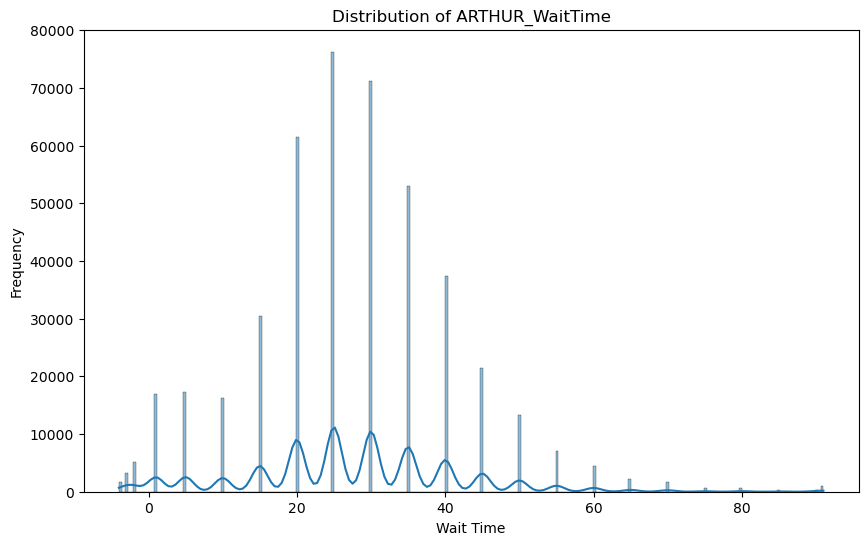

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Histogram for a wait time column
wait_time_columns = [col for col in park_open_df.columns if 'WaitTime' in col]
if wait_time_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(park_open_df[wait_time_columns[0]].dropna(), kde=True)
    plt.title(f'Distribution of {wait_time_columns[0]}')
    plt.xlabel('Wait Time')
    plt.ylabel('Frequency')
    plt.show()

# Example: Histogram for Temperature 
if 'temp_value' in park_open_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(park_open_df['temp_value'].dropna(), kde=True)
    plt.title('Distribution of Temperature (temp_value)')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.show()

### Correlation Analysis

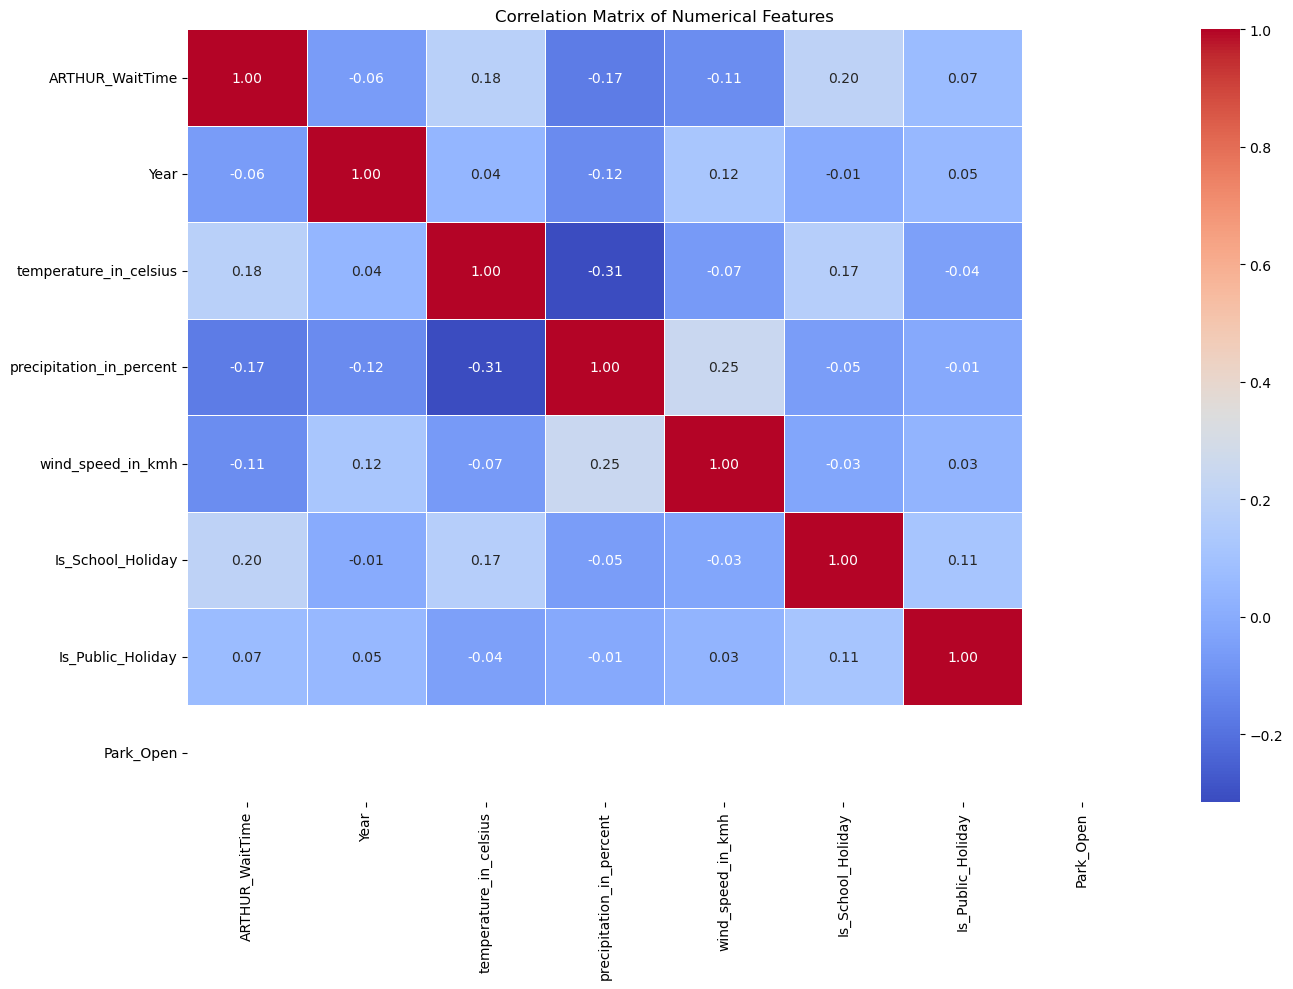

In [27]:
# Select only numerical columns for correlation analysis
numeric_cols = park_open_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove unnecessary numeric columns (like index) if they exist
exclude_cols = []  # Add columns to exclude if needed
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

# Create a correlation matrix for these numeric columns
if numeric_cols:
    correlation_matrix = park_open_df[numeric_cols].corr(method='pearson', numeric_only=True)
    
    # Plot the correlation matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found for correlation analysis")

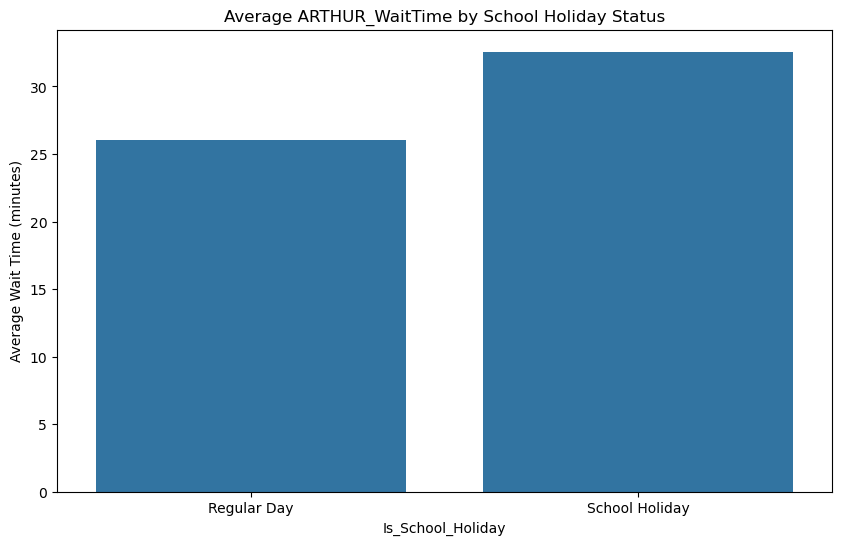

Wait time statistics by school holiday status:
  Is_School_Holiday       mean  median        std
0       Regular Day  26.033911    25.0  14.046067
1    School Holiday  32.585196    30.0  11.986352


In [28]:
# Explore relationship between wait time and holidays
wait_time_columns = [col for col in park_open_df.columns if 'WaitTime' in col]
if wait_time_columns and 'Is_School_Holiday' in park_open_df.columns:
    # Pick a representative wait time column
    wait_col = wait_time_columns[0]
    
    # Filter out values < 0 (probably maintenance or closed)
    df_filtered = park_open_df[park_open_df[wait_col] >= 0].copy()
    
    # Calculate average wait time on school holidays vs regular days
    avg_by_holiday = df_filtered.groupby('Is_School_Holiday')[wait_col].agg(['mean', 'median', 'std']).reset_index()
    avg_by_holiday['Is_School_Holiday'] = avg_by_holiday['Is_School_Holiday'].map({0: 'Regular Day', 1: 'School Holiday'})
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Is_School_Holiday', y='mean', data=avg_by_holiday)
    plt.title(f'Average {wait_col} by School Holiday Status')
    plt.ylabel('Average Wait Time (minutes)')
    plt.show()
    
    print(f"Wait time statistics by school holiday status:\n{avg_by_holiday}")

/tmp/ipykernel_615650/480812707.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_time['Hour'] = pd.to_datetime(df_time['Time']).dt.hour


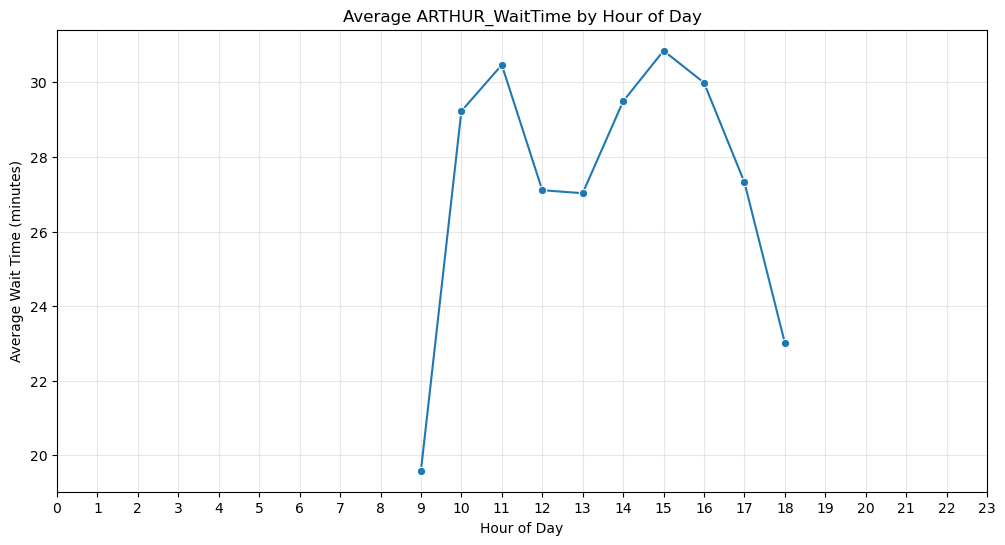

In [29]:
# Explore wait time by time of day
if wait_time_columns and 'Time' in park_open_df.columns:
    # Extract hour from time column
    df_time = park_open_df.copy()
    try:
        # Try to extract hour directly if Time is already properly formatted
        df_time['Hour'] = pd.to_datetime(df_time['Time']).dt.hour
    except:
        # If that fails, try a different approach assuming 'Time' is a string like '10:30'
        df_time['Hour'] = df_time['Time'].str.split(':', expand=True)[0].astype(int)
    
    # Filter out negative wait times
    wait_col = wait_time_columns[0]
    df_time = df_time[df_time[wait_col] >= 0]
    
    # Group by hour and calculate average wait time
    hourly_avg = df_time.groupby('Hour')[wait_col].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Hour', y=wait_col, data=hourly_avg, marker='o')
    plt.title(f'Average {wait_col} by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Wait Time (minutes)')
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.show()

In [30]:
# Explore the relationship between weather and wait times
if wait_time_columns and 'temp_value' in park_open_df.columns:
    wait_col = wait_time_columns[0]
    df_filtered = park_open_df[(park_open_df[wait_col] >= 0) & (~park_open_df['temp_value'].isna())].copy()
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='temp_value', y=wait_col, data=df_filtered, alpha=0.5)
    plt.title(f'Relationship Between Temperature and {wait_col}')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Wait Time (minutes)')
    
    # Add a trend line
    sns.regplot(x='temp_value', y=wait_col, data=df_filtered, scatter=False, color='red')
    plt.show()
    
    # Calculate correlation
    correlation = df_filtered[['temp_value', wait_col]].corr().iloc[0, 1]
    print(f"Correlation between temperature and {wait_col}: {correlation:.3f}")

## Forecasting using Differencing with Linear Regression

This approach aims to forecast the change in waiting times instead of their absolute
values. By differencing the time series, seasonalities and trends can be removed, often
making the series more stationary and easier to model with simpler algorithms like
Linear Regression. The final prediction is then reconstructed by adding the predicted
difference to the last known actual value.

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Select the main attraction wait time for forecasting
wait_time_columns = [col for col in park_open_df.columns if 'WaitTime' in col]
if not wait_time_columns:
    raise ValueError("No wait time columns found in the dataset")

# For this example, we'll use the first wait time column (ARTHUR_WaitTime)
target_column = wait_time_columns[0]
print(f"Selected target column for forecasting: {target_column}")

# Phase 1: Data Preparation and Feature Engineering
# ------------------------------------------------

# 1. Initial preprocessing
# Create a copy to avoid modifying the original dataframe
df_forecast = park_open_df.copy()

# Convert Date to datetime if it's not already
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

# Create a DateTime column combining Date and Time
df_forecast['DateTime'] = pd.to_datetime(df_forecast['Date'].astype(str) + ' ' + df_forecast['Time'])

# Sort by DateTime to ensure chronological order
df_forecast = df_forecast.sort_values('DateTime').reset_index(drop=True)

# Handle missing or negative values in target column (these could be maintenance periods)
df_forecast = df_forecast[df_forecast[target_column] >= 0].copy()

# 2. Generate Original Lag1 (for Reconstruction)
df_forecast[f'{target_column}_lag1_original'] = df_forecast[target_column].shift(1)

# 3. Calculate Differenced Series
df_forecast[f'{target_column}_diff'] = df_forecast[target_column] - df_forecast[f'{target_column}_lag1_original']

# 4. Handle NaNs from Differencing/Lagging
df_forecast = df_forecast.dropna(subset=[f'{target_column}_diff', f'{target_column}_lag1_original'])

# 5. Generate Lag Features for Differenced Series
df_forecast[f'{target_column}_diff_lag1'] = df_forecast[f'{target_column}_diff'].shift(1)
df_forecast[f'{target_column}_diff_lag2'] = df_forecast[f'{target_column}_diff'].shift(2)
# Add more lag features for better time dependency capture
df_forecast[f'{target_column}_diff_lag3'] = df_forecast[f'{target_column}_diff'].shift(3)
df_forecast[f'{target_column}_diff_lag4'] = df_forecast[f'{target_column}_diff'].shift(4)

# 6. Extract Time-Based Features
df_forecast['hour_of_day'] = df_forecast['DateTime'].dt.hour
df_forecast['day_of_week'] = df_forecast['DateTime'].dt.dayofweek
df_forecast['day_of_year'] = df_forecast['DateTime'].dt.dayofyear
df_forecast['month'] = df_forecast['DateTime'].dt.month
df_forecast['is_weekend'] = df_forecast['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_forecast['minute_of_hour'] = df_forecast['DateTime'].dt.minute

# Add more temporal features
# Time of day segmentation (morning, afternoon, evening)
df_forecast['time_segment'] = df_forecast['hour_of_day'].apply(
    lambda x: 0 if x < 12 else 1 if x < 17 else 2)  # Morning, Afternoon, Evening

# Feature columns for the model
feature_columns = [
    f'{target_column}_diff_lag1', 
    f'{target_column}_diff_lag2',
    f'{target_column}_diff_lag3',
    f'{target_column}_diff_lag4',
    'hour_of_day',
    'day_of_week',
    'day_of_year',
    'month',
    'is_weekend',
    'minute_of_hour',
    'time_segment',
    
]

# Add interaction term if available
if 'temp_weekend_interaction' in df_forecast.columns:
    feature_columns.append('temp_weekend_interaction')

# Add holiday features if they exist
if 'Is_School_Holiday' in df_forecast.columns:
    feature_columns.append('Is_School_Holiday')
if 'Is_Public_Holiday' in df_forecast.columns:
    feature_columns.append('Is_Public_Holiday')
    
# Add weather features if they exist
weather_cols = ['temp_value', 'precipitation_in_percent', 'wind_speed_in_kmh']
for col in weather_cols:
    if col in df_forecast.columns:
        feature_columns.append(col)

# Define Features (X) and Labels (y)
X = df_forecast[feature_columns]
y = df_forecast[f'{target_column}_diff']  # Target is the differenced series

Selected target column for forecasting: ARTHUR_WaitTime


## Model Training and Prediction


Mean Absolute Error for Differenced Linear Regression: 0.31 minutes
Mean Absolute Error for Persistence Baseline: 0.25 minutes
Improvement over persistence baseline: -23.04%


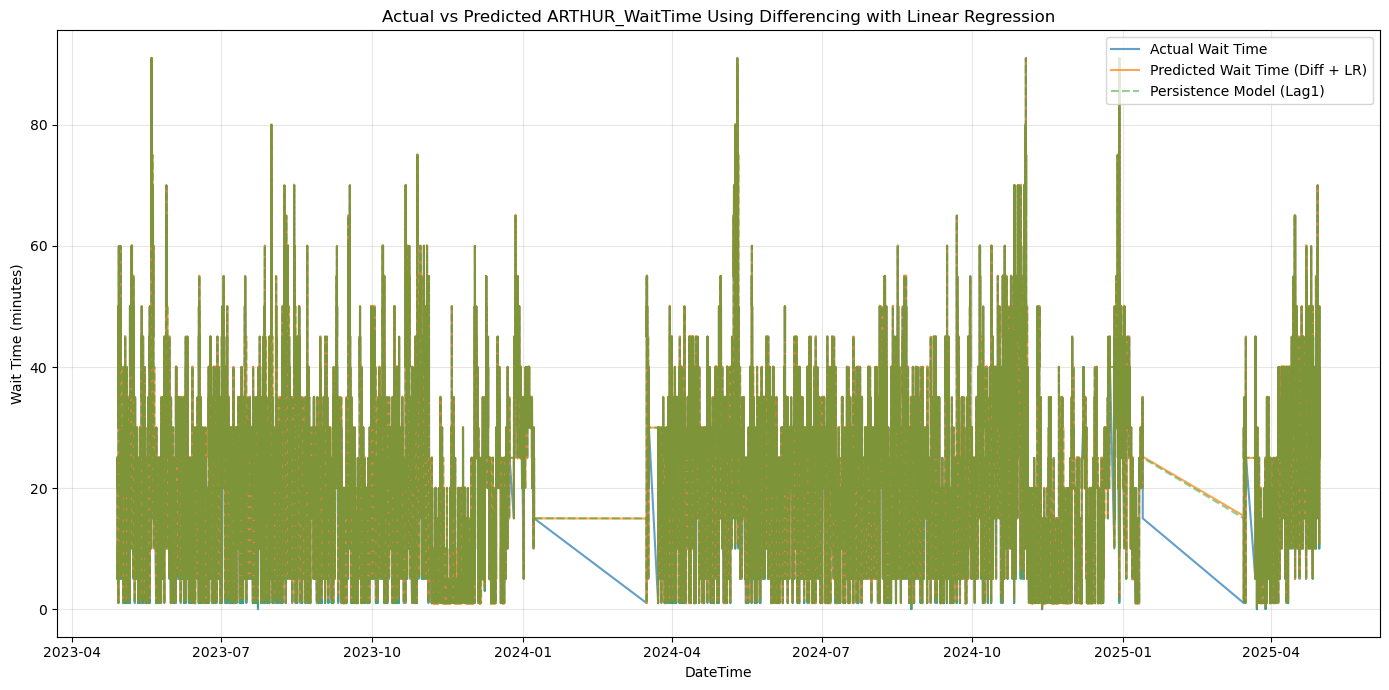

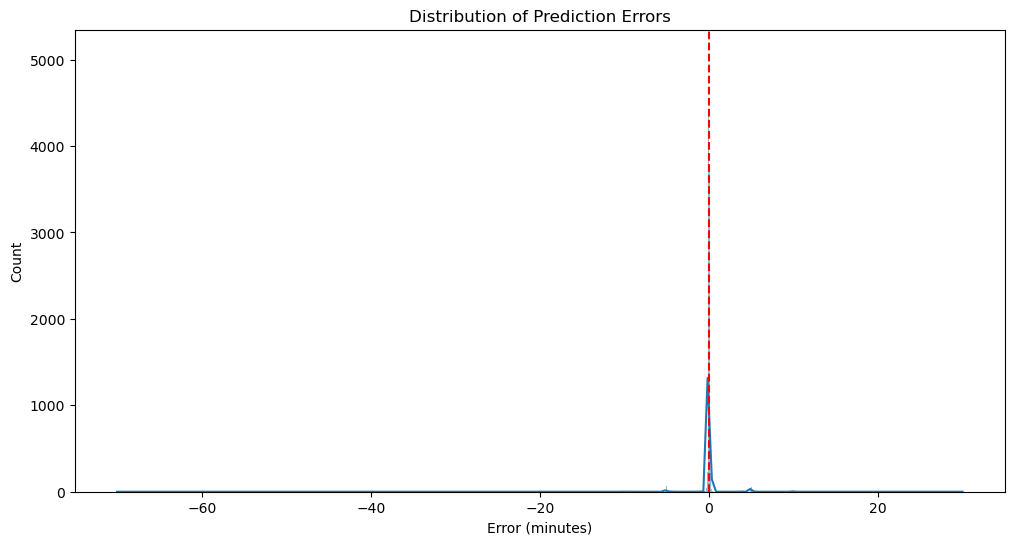


Error Statistics:
Mean error: 0.00 minutes
Standard deviation of error: 1.52 minutes
Median error: 0.00 minutes


In [ ]:
# 1. Data Splitting
test_size = 0.7  # Using 50% for testing as specified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

# Save the indices for later reference
train_indices = X_train.index
test_indices = X_test.index

# 2. Handle missing values in features (impute with column mean)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # Use train mean for test set

# 3. Model Initialization
model = LinearRegression()

# 3. Model Training
model.fit(X_train, y_train)

# 4. Prediction of Differences
y_pred_diff = model.predict(X_test)

# Phase 3: Reconstruction and Evaluation
# ------------------------------------

# 1. Reconstruction of Total Wait Times
# Get original lag1 values for test set
original_lag1_test = df_forecast.loc[test_indices, f'{target_column}_lag1_original']

# Reconstruct the absolute wait times by adding predicted differences to the lag1 values
y_pred_reconstructed = original_lag1_test.values + y_pred_diff

# 2. Model Performance Metric
# Get actual wait times from the test set for comparison
y_true = df_forecast.loc[test_indices, target_column].values

# Calculate MAE for the differenced model
mae_diff_model = mean_absolute_error(y_true, y_pred_reconstructed)
print(f"\nMean Absolute Error for Differenced Linear Regression: {mae_diff_model:.2f} minutes")

# 3. Persistence Baseline (Original Values)
# Persistence model simply uses the last known value (lag1) as the prediction
mae_persistence = mean_absolute_error(y_true, original_lag1_test.values)
print(f"Mean Absolute Error for Persistence Baseline: {mae_persistence:.2f} minutes")

# 4. Comparison and Interpretation
improvement = (mae_persistence - mae_diff_model) / mae_persistence * 100
print(f"Improvement over persistence baseline: {improvement:.2f}%")

# 5. Visualizations
plt.figure(figsize=(14, 7))
plt.plot(df_forecast.loc[test_indices, 'DateTime'], y_true, label='Actual Wait Time', alpha=0.7)
plt.plot(df_forecast.loc[test_indices, 'DateTime'], y_pred_reconstructed, 
         label='Predicted Wait Time (Diff + LR)', alpha=0.7)
plt.plot(df_forecast.loc[test_indices, 'DateTime'], original_lag1_test, 
         label='Persistence Model (Lag1)', alpha=0.5, linestyle='--')

plt.title(f'Actual vs Predicted {target_column} Using Differencing with Linear Regression')
plt.xlabel('DateTime')
plt.ylabel('Wait Time (minutes)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot the distribution of prediction errors
plt.figure(figsize=(12, 6))
errors = y_true - y_pred_reconstructed
sns.histplot(errors, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (minutes)')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

print(f"\nError Statistics:")
print(f"Mean error: {np.mean(errors):.2f} minutes")
print(f"Standard deviation of error: {np.std(errors):.2f} minutes")
print(f"Median error: {np.median(errors):.2f} minutes")

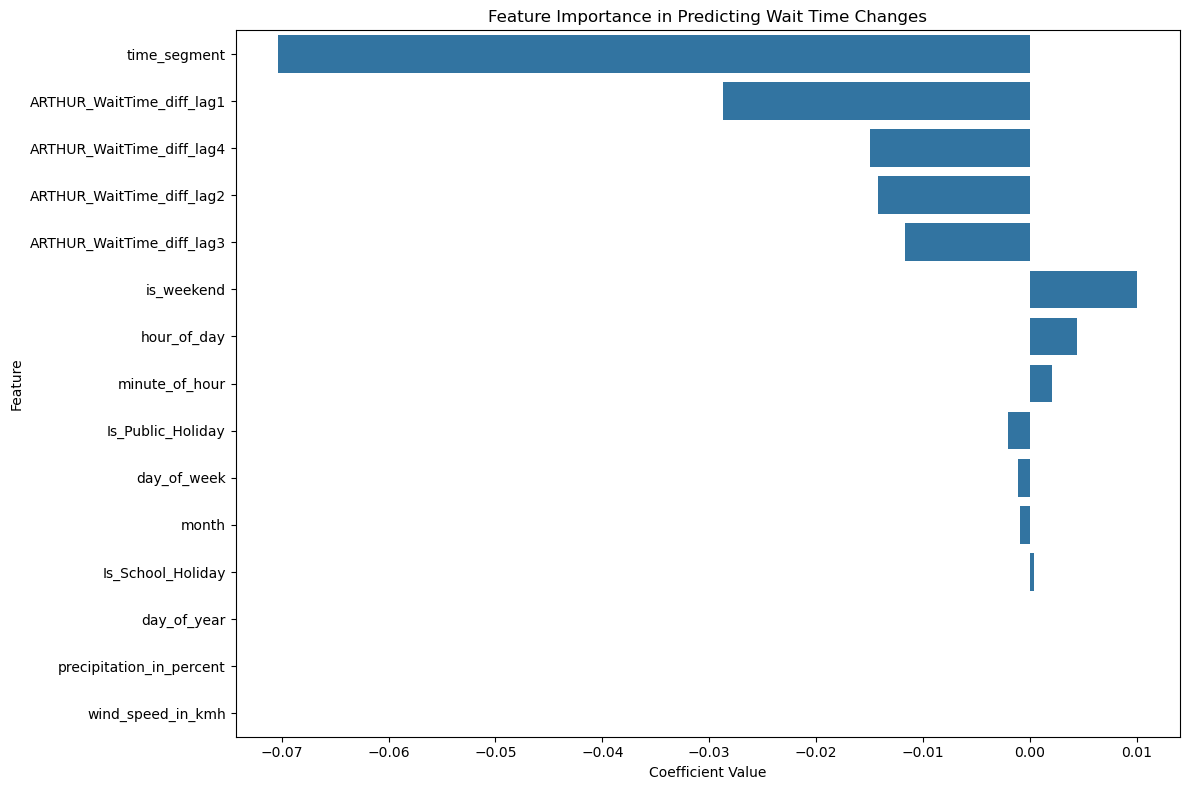

Top 5 most important features:
                      Feature  Importance
10               time_segment   -0.070309
0   ARTHUR_WaitTime_diff_lag1   -0.028683
3   ARTHUR_WaitTime_diff_lag4   -0.014944
1   ARTHUR_WaitTime_diff_lag2   -0.014187
2   ARTHUR_WaitTime_diff_lag3   -0.011686


In [ ]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': model.coef_
})

feature_importance = feature_importance.sort_values('Importance', key=abs, ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Predicting Wait Time Changes')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

print("Top 5 most important features:")
print(feature_importance.head(5))

### Conclusion

The differencing approach with Linear Regression provides a forecasting model for theme park wait times. By modeling the changes in wait times rather than absolute values, this approach attempts to make the time series more stationary and suitable for linear modeling.

The model's performance can be assessed by comparing it to a simple persistence baseline. If the MAE is significantly lower than the persistence baseline, the model is adding predictive value beyond simply assuming wait times remain constant.

Key points:
1. Differencing helps reduce non-stationarity issues in the time series
2. The model reconstructs absolute wait times by adding predicted differences to last known values
3. Feature importance reveals which factors most strongly influence changes in wait times
4. The approach is interpretable and relatively simple compared to more complex time series models

## Model Accuracy

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate R-squared
r2 = r2_score(y_test, y_pred_reconstructed)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_reconstructed)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

R-squared: -395.2906437187913
Mean Squared Error: 897.7122325576498


### Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

# Impute missing values for cross-validation
X_imputed = X.fillna(X.mean())

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X_imputed, y, cv=5, scoring='r2')

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [ 0.00137033  0.00064027  0.00052644  0.00062096 -0.00114251]
Mean cross-validation score: 0.0004030954544141263


### Results Interpretation

The R-squared value is negative, which means that the model is performing worse than simply predicting the mean of the target variable. The cross-validation scores are also very close to zero, which confirms that the model has low predictive power. This indicates that the current features are not sufficient to predict the wait times accurately.